# Data Challenge Description

The file data.csv contains several columns of information for your analysis. The data are synthetic but were constructed to mimic data that we observe from real-world satellite images.

The car.count column shows the number of cars observed in a parking lot for a retail location like a WalMart or Home Depot. The weather and cloud.indicator columns tell something about whether the parking lot was visible each day.

We would like you to do some exploration of the data, fit some simple models, and summarize what you find, with the goal of both describing the data included and being able to forecast future values. We have in mind this should take no more than a couple of hours.

We are interested to know what you find, but also how you go about finding it. What process? What methods? What intuitions did you use to guide your investigation? Why did you do "this" or "that."

*Please produce some output including plots and other results to explain what you find and how you did it. Don't worry too much about making the output and plots pretty -- well organized is good enough.

Please use any analysis tools and methods that you wish for this project as long as you can explain what each is doing and why you chose to use it. 


Some example questions to answer:

1) Summarize in a qualitative way what you see in the data when you first look it over. What does this suggest for your "plan of attack" for your analysis? What techniques might be appropriate and useful?

2) How would you characterize your findings quantitatively?

3) What additional analysis might be useful if you had a whole day to work on the problem?




Our team will review your work and get back to you. We may ask to schedule a follow-up call if we would like to further review your work with you on a video call.

In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from matplotlib import pyplot as plt
import numpy as np
import glob, re
import seaborn as sns
from datetime import datetime,date
np.random.seed(41)
import calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

# Load and process the data

In [77]:
%%bash
ls data/

data.csv


In [78]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator
0,2010-01-01,Friday,101,0.1,clear
1,2010-01-02,Saturday,34,0.2,cloudy
2,2010-01-03,Sunday,113,0.4,clear
3,2010-01-04,Monday,5,0.6,cloudy
4,2010-01-05,Tuesday,124,0.1,clear


In [210]:
data = pd.read_csv('data/data.csv')
data['date'] = pd.to_datetime(data['date'])
data['month.of.year'] = data['date'].dt.month
data['month.of.year'] = data['month.of.year'].apply(lambda x: calendar.month_name[x])
data['year'] = data['date'].dt.year
data['date']=data['date'].dt.date
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year
0,2010-01-01,Friday,101,0.1,clear,January,2010
1,2010-01-02,Saturday,34,0.2,cloudy,January,2010
2,2010-01-03,Sunday,113,0.4,clear,January,2010
3,2010-01-04,Monday,5,0.6,cloudy,January,2010
4,2010-01-05,Tuesday,124,0.1,clear,January,2010


In [4]:
data.shape

(2373, 5)

In [5]:
data.dtypes

date                object
day.of.week         object
car.count            int64
weather            float64
cloud.indicator     object
dtype: object

In [7]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator
0,2010-01-01,Friday,101,0.1,clear
1,2010-01-02,Saturday,34,0.2,cloudy
2,2010-01-03,Sunday,113,0.4,clear
3,2010-01-04,Monday,5,0.6,cloudy
4,2010-01-05,Tuesday,124,0.1,clear


In [8]:
data['date'].describe()

count                    2373
unique                   2373
top       2015-10-18 00:00:00
freq                        1
first     2010-01-01 00:00:00
last      2016-06-30 00:00:00
Name: date, dtype: object

We have single data point for all dates

In [118]:
data.isnull().values.any()

False

We don't have any missing values

In [9]:
nan_rows = data[data.isnull().T.any().T]
nan_rows

,date,day.of.week,car.count,weather,cloud.indicator


In [211]:
print(data['date'].is_monotonic)
print(data.sample(frac=1)['date'].is_monotonic)
print(data['car.count'].is_monotonic)
print(data.sort_values('date',inplace=True))

True
False
False
None


# Exploratory Data Analysis

## Cloud indicator vs car count

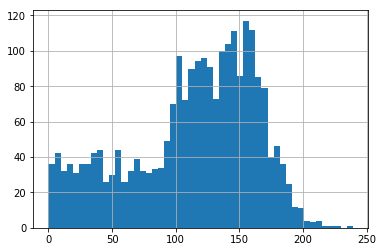

In [10]:
data['car.count'].hist(bins=50)

In [11]:
data['cloud.indicator'].unique()

array(['clear', 'cloudy'], dtype=object)

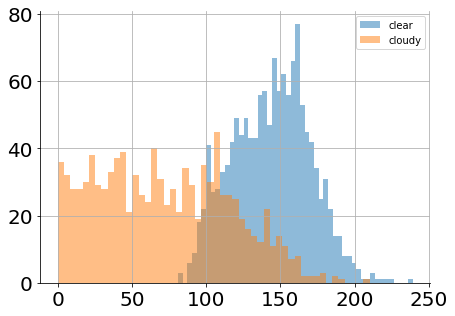

In [12]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[data['cloud.indicator']=='clear','car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[data['cloud.indicator']=='cloudy','car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

Clearly the distribution of car counts are very different if we have a cloudy day.

## Day of the week and month of the year vs car_count

(40, 100)

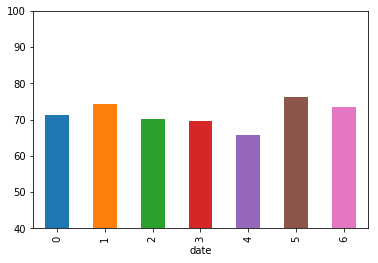

In [17]:
data[data['cloud.indicator']=='cloudy'].groupby(data['date'].dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

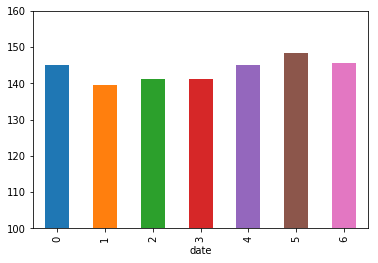

In [32]:
data[data['cloud.indicator']=='clear'].groupby(data['date'].dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((100,160))

(100, 160)

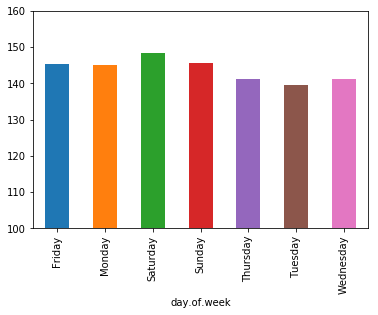

In [30]:
data[data['cloud.indicator']=='clear'].groupby('day.of.week')['car.count'].mean().plot.bar()
plt.ylim((100,160))

There doesn't seem to be a strong variation between weekdays

In [24]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year
0,2010-01-01,Friday,101,0.1,clear,January,2010
1,2010-01-02,Saturday,34,0.2,cloudy,January,2010
2,2010-01-03,Sunday,113,0.4,clear,January,2010
3,2010-01-04,Monday,5,0.6,cloudy,January,2010
4,2010-01-05,Tuesday,124,0.1,clear,January,2010


(40, 100)

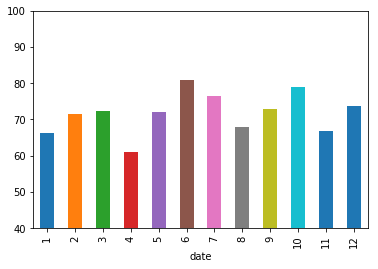

In [33]:
data[data['cloud.indicator']=='cloudy'].groupby(data['date'].dt.month)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

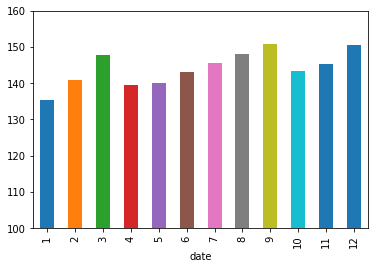

In [34]:
data[data['cloud.indicator']=='clear'].groupby(data['date'].dt.month)['car.count'].mean().plot.bar()
plt.ylim((100,160))

(100, 160)

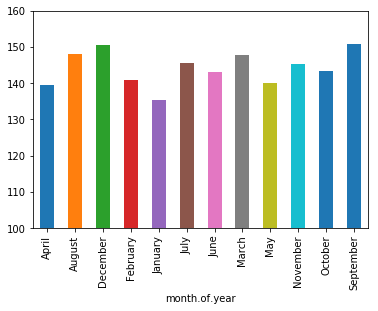

In [35]:
data[data['cloud.indicator']=='clear'].groupby('month.of.year')['car.count'].mean().plot.bar()
plt.ylim((100,160))

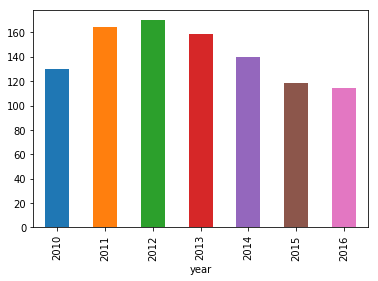

In [36]:
data[data['cloud.indicator']=='clear'].groupby('year')['car.count'].mean().plot.bar()
#plt.ylim((100,160))

Most likely there is recovery after financial crisis followed by retail apocalypse

## Weather vs car_count

In [37]:
data['weather'].unique()

array([ 0.1,  0.2,  0.4,  0.6, -0.1, -1. , -0.3,  1.4, -0.8, -0.5, -1.9,
       -0.6,  0. , -0.9,  0.5,  1.7, -1.5,  1.2,  0.7,  0.8, -1.3, -0.4,
        0.9,  0.3, -1.2,  1.3,  3.1, -0.7,  1.8,  1.5, -0.2, -1.4,  2.3,
       -2.2, -1.6,  1. ,  1.1, -1.7, -1.8, -2.3, -1.1,  3.8,  2.6, -2. ,
        1.9, -2.7,  2. , -2.4,  3.2, -2.1, -2.9,  2.1,  1.6,  2.4,  2.2,
       -2.5,  2.5, -3. ,  2.7,  4.3, -3.2,  3. ,  2.8, -3.1, -2.6,  3.3])

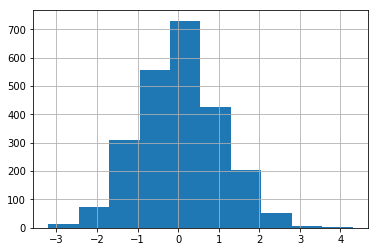

In [38]:
data['weather'].hist()

Looks like weather is a standard normal distribution

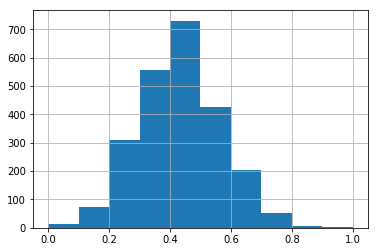

In [107]:
pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['weather'].values.reshape(-1, 1))[:,0],name='weather').hist()

### Is there a relationship between car.count and weather?

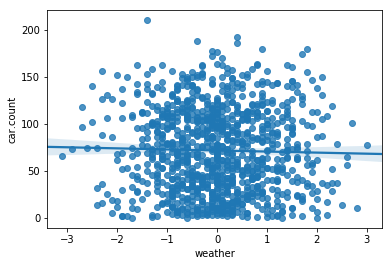

In [40]:
ax = sns.regplot(x="weather", y="car.count", data=data[data['cloud.indicator']=='cloudy'])

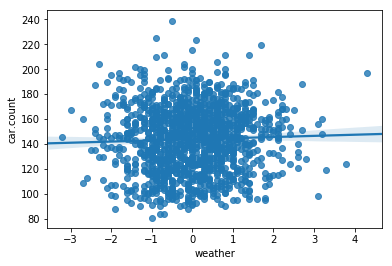

In [41]:
ax = sns.regplot(x="weather", y="car.count", data=data[data['cloud.indicator']=='clear'])

In [42]:
from scipy.stats import linregress
x = data.loc[data['cloud.indicator']=='clear','weather']
y = data.loc[data['cloud.indicator']=='clear','car.count']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

0.915771031498 143.79697777 0.0356701186341 0.189768636391 0.698036622271


In [43]:
x = data.loc[data['cloud.indicator']=='cloudy','weather']
y = data.loc[data['cloud.indicator']=='cloudy','car.count']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

-1.13286755713 71.6014973257 -0.0254626865137 0.41659223141 1.39399172199


There doesn't seem to be an significant relationship between weather and car count

## Time vs car_count

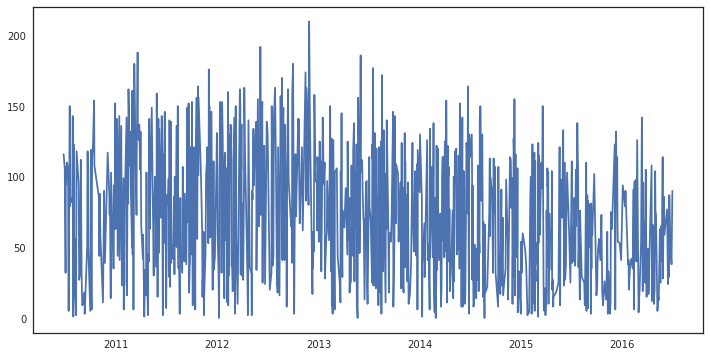

In [226]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='cloudy','date']
y = data.loc[data['cloud.indicator']=='cloudy','car.count']
plt.plot(x,y)

## Calculate a moving average

In [213]:
temp = data.merge(right = data[['date','car.count']].loc[data['cloud.indicator']=='clear'].rolling(window=100).median().rename(columns={'car.count':'100_moving_ave'}),
                  on='date',how='left')
print(temp['100_moving_ave'].first_valid_index())
data = temp[temp.index>=167]
data.reset_index(drop=True,inplace=True)
print(data.head())
data.tail()

167
         date day.of.week  car.count  weather cloud.indicator month.of.year  \
0  2010-06-17    Thursday        119      0.7           clear          June   
1  2010-06-18      Friday        128      1.3           clear          June   
2  2010-06-19    Saturday        128     -0.8           clear          June   
3  2010-06-20      Sunday        166     -0.9           clear          June   
4  2010-06-21      Monday        123      0.0           clear          June   

   year  100_moving_ave  
0  2010           113.0  
1  2010           113.5  
2  2010           114.5  
3  2010           114.5  
4  2010           115.0  


,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,100_moving_ave
2201,2016-06-26,Sunday,102,0.1,clear,June,2016,112.5
2202,2016-06-27,Monday,38,0.6,cloudy,June,2016,NaN
2203,2016-06-28,Tuesday,95,-1.6,clear,June,2016,112.0
2204,2016-06-29,Wednesday,104,-0.1,clear,June,2016,112.0
2205,2016-06-30,Thursday,90,-0.3,cloudy,June,2016,NaN


In [214]:
data.shape

(2206, 8)

In [215]:
data = data.fillna(method='ffill')

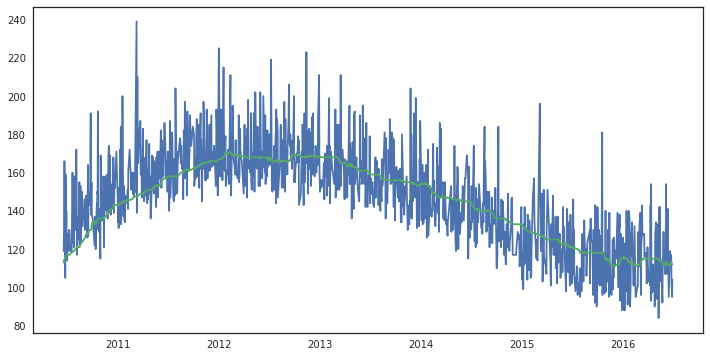

In [216]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='clear','date']
y = data.loc[data['cloud.indicator']=='clear','car.count']
plt.plot(x,y)
plt.plot(x,data.loc[data['cloud.indicator']=='clear','100_moving_ave'])

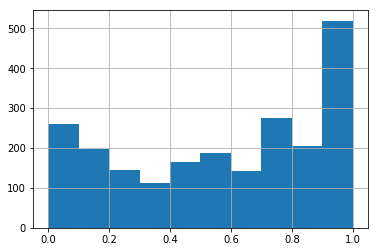

In [118]:
pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave'].values.reshape(-1, 1))[:,0],name='100_day_ave').hist()

## How well can we predict car count?

In [217]:
print(data.shape)
print(data.head())
data.tail()

(2206, 8)
         date day.of.week  car.count  weather cloud.indicator month.of.year  \
0  2010-06-17    Thursday        119      0.7           clear          June   
1  2010-06-18      Friday        128      1.3           clear          June   
2  2010-06-19    Saturday        128     -0.8           clear          June   
3  2010-06-20      Sunday        166     -0.9           clear          June   
4  2010-06-21      Monday        123      0.0           clear          June   

   year  100_moving_ave  
0  2010           113.0  
1  2010           113.5  
2  2010           114.5  
3  2010           114.5  
4  2010           115.0  


,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,100_moving_ave
2201,2016-06-26,Sunday,102,0.1,clear,June,2016,112.5
2202,2016-06-27,Monday,38,0.6,cloudy,June,2016,112.5
2203,2016-06-28,Tuesday,95,-1.6,clear,June,2016,112.0
2204,2016-06-29,Wednesday,104,-0.1,clear,June,2016,112.0
2205,2016-06-30,Thursday,90,-0.3,cloudy,June,2016,112.0


### Preprocessing steps for Linear Regression

In [218]:
X = pd.concat([pd.get_dummies(data[['day.of.week','month.of.year']]),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
              data[['car.count','date']],
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['weather'].values.reshape(-1, 1))[:,0],name='weather'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave'].values.reshape(-1, 1))[:,0],name='100_moving_ave')],
              axis=1)
X.head()

,day.of.week_Friday,day.of.week_Monday,day.of.week_Saturday,day.of.week_Sunday,day.of.week_Thursday,day.of.week_Tuesday,day.of.week_Wednesday,month.of.year_April,month.of.year_August,month.of.year_December,...,month.of.year_March,month.of.year_May,month.of.year_November,month.of.year_October,month.of.year_September,cloud.indicator,car.count,date,weather,100_moving_ave
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,119,2010-06-17,0.520000,0.033613
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,128,2010-06-18,0.600000,0.042017
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,128,2010-06-19,0.320000,0.058824
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,166,2010-06-20,0.306667,0.058824
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,123,2010-06-21,0.426667,0.067227


In [219]:
X.isnull().values.any()


False

In [220]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2015,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

(1659, 24) (546, 24)


In [221]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Ridge regression

In [222]:
from sklearn.linear_model import Ridge

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = Ridge(alpha=10.0, 
            fit_intercept=True, 
            normalize=False, 
            copy_X=True, 
            max_iter=None, 
            tol=0.001, solver='auto', random_state=None)
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score for the mean model',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.60861993197
explained_variance_score 0.319108785207
explained_variance_score for the mean model 0.0
mean_absolute_error 23.9765582886
mean_absolute_percentage_error 26.5462636624
mean_absolute_percentage_error for the mean model 35.1221158617


In [223]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score for the mean model',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.469716225047
explained_variance_score 0.489648377665
explained_variance_score for the mean model 0.0
mean_absolute_error 23.781082928
mean_absolute_percentage_error 30.6515830456
mean_absolute_percentage_error for the mean model 35.3861457353


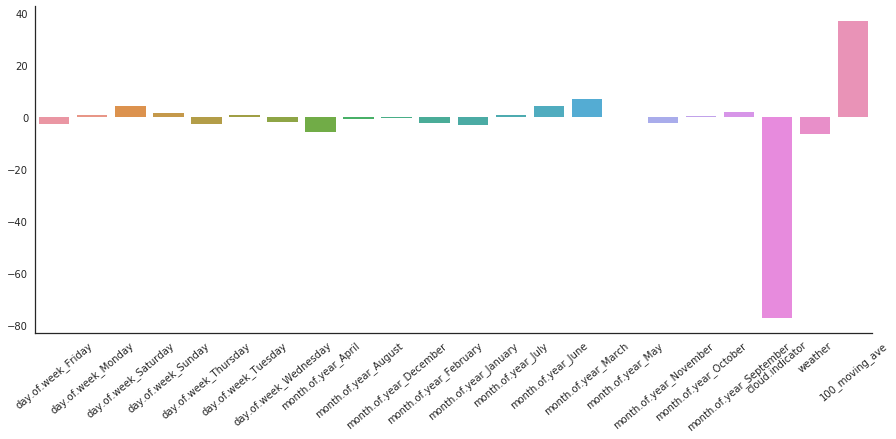

In [224]:
plt.figure(figsize=(15,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

# Lasso

In [204]:
from sklearn.linear_model import Lasso

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = Lasso(alpha=1, fit_intercept=True, 
            normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, 
            warm_start=False, positive=False, random_state=None, selection='cyclic')
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.593703200804
explained_variance_score 0.221433648217
explained_variance_score 0.0
mean_absolute_error 24.7497113231
mean_absolute_percentage_error 26.6583666493
mean_absolute_percentage_error for the mean model 35.1221158617


In [205]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.314645771036
explained_variance_score 0.463260796731
explained_variance_score 0.0
mean_absolute_error 28.4480835941
mean_absolute_percentage_error 30.4677442749
mean_absolute_percentage_error for the mean model 35.3861457353


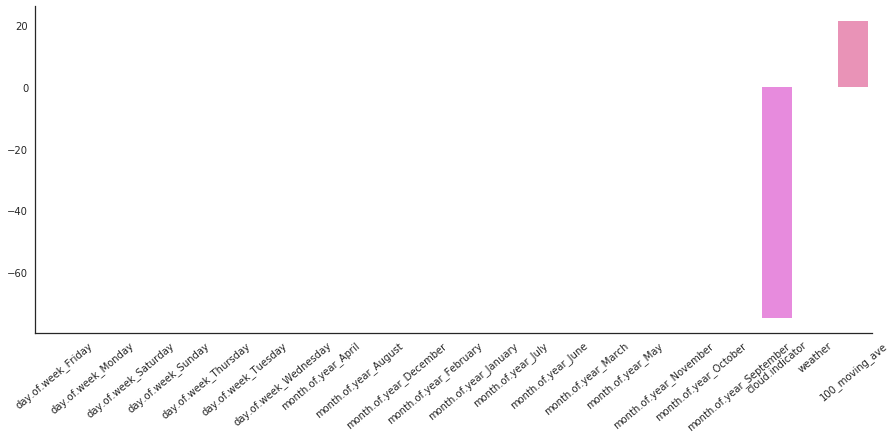

In [206]:
plt.figure(figsize=(15,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

# Decision tree regression

In [157]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,100_moving_ave
0,2010-06-17,Thursday,119,0.7,clear,June,2010,113.0
1,2010-06-18,Friday,128,1.3,clear,June,2010,113.5
2,2010-06-19,Saturday,128,-0.8,clear,June,2010,114.5
3,2010-06-20,Sunday,166,-0.9,clear,June,2010,114.5
4,2010-06-21,Monday,123,0.0,clear,June,2010,115.0


## Preprocessing steps for decision tree regression

In [158]:
X = pd.concat([pd.Series(data['month.of.year'].factorize()[0],name='month.of.year'),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
               pd.Series(data['day.of.week'].factorize()[0],name='day.of.week'),
              data[['car.count','date','weather','100_moving_ave']]],axis=1)
X.head()

,month.of.year,cloud.indicator,day.of.week,car.count,date,weather,100_moving_ave
0,0,0,0,119,2010-06-17,0.7,113.0
1,0,0,1,128,2010-06-18,1.3,113.5
2,0,0,2,128,2010-06-19,-0.8,114.5
3,0,0,3,166,2010-06-20,-0.9,114.5
4,0,0,4,123,2010-06-21,0.0,115.0


In [159]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2015,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

(1659, 7) (546, 7)


In [160]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train.drop(['date','car.count'],axis=1),  X_train['car.count'])

lgb_eval = lgb.Dataset(X_valid.drop(['date','car.count'],axis=1),  X_valid['car.count'])

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2'},
    #'num_leaves': 8,
    'learning_rate': 0.1,
    'verbose': 50
}
print('Start training...')
# train
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                evals_result=evals_result,
                early_stopping_rounds=1)

Start training...
[1]	valid_0's l2: 2193.41
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's l2: 1968.9
[3]	valid_0's l2: 1792.51
[4]	valid_0's l2: 1647.82
[5]	valid_0's l2: 1540.98
[6]	valid_0's l2: 1450.07
[7]	valid_0's l2: 1382.44
[8]	valid_0's l2: 1307.87
[9]	valid_0's l2: 1243.94
[10]	valid_0's l2: 1193.97
[11]	valid_0's l2: 1153.24
[12]	valid_0's l2: 1133.09
[13]	valid_0's l2: 1099.6
[14]	valid_0's l2: 1083.21
[15]	valid_0's l2: 1056.08
[16]	valid_0's l2: 1033.18
[17]	valid_0's l2: 1026.18
[18]	valid_0's l2: 1010.41
[19]	valid_0's l2: 1005.4
[20]	valid_0's l2: 994.696
[21]	valid_0's l2: 984.594
[22]	valid_0's l2: 977.838
[23]	valid_0's l2: 969.667
[24]	valid_0's l2: 972.683
Early stopping, best iteration is:
[23]	valid_0's l2: 969.667


In [161]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = gbm.predict(x, num_iteration=gbm.best_iteration)
print('R2',r2_score(y_true,y_pred)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y.mean()), y_true)) # this is R2 value

R2 0.388971691693
explained_variance_score 0.287061264551
explained_variance_score -1.96454056883e+30
mean_absolute_error 25.5079712883
mean_absolute_percentage_error 28.2171133047
mean_absolute_percentage_error for the mean model 37.3239588273


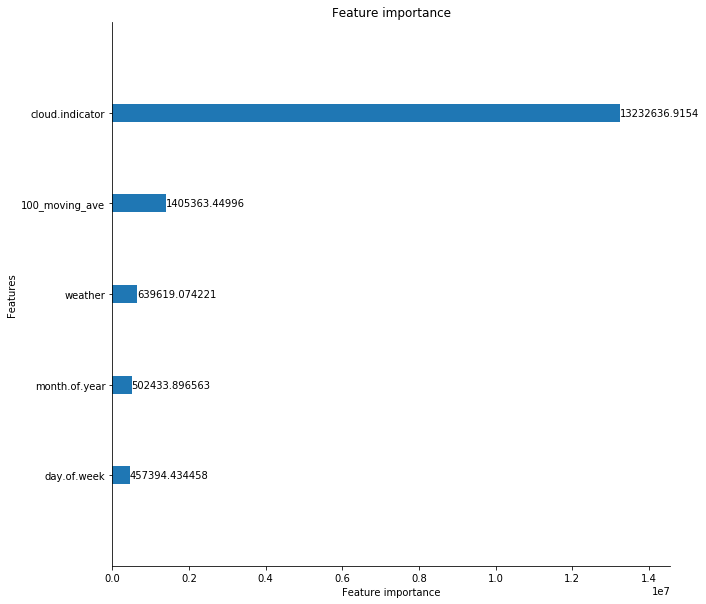

In [162]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='gain')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

# Conclusion:

I started by making sure that there are no missing values and the data is sorted on date. This is pretty important for time-series data. After EDA, I found that having a cloudy day impairs having an accurate estimate of car counts. There are weak variations in car counts depending on the day of the week or month of the year. I also did not find a correlation between weather and car counts. There was however strong long term trends when looking at years seperately, with the highest amount of cars present in 2012. I also constructed models in order to predict feature values of car counts. My initial models were really bad. However by including a 100 day moving median, I was able to capture long-term trends, and this significantly improved my models. I was able to obtain R2 value of around 0.4 in the validation data, which is not great, but it shows that we have a significant imporevement compared to a mean model. Looking for coefficients of both linear models and non-linear models we can see that the most important coefficient is cloud_indicator, and this makes sense. If it is cloudy there are less cars. The second most important coefficient is 100-day moving average, and the other coefficients have a very small role in terms of being able to predict the number of car counts.

Given more time I would:

1) Tune models; for example find the best regularization coefficients.
2) Try to work on identifying outliers by doing someting like bollinger bands or RSI (this was a question in my phone talk with Steve).
3) Include week of the month and see if this imporves the model (I doubt it)
4) Engineer another feature such as how many days back to back it was cloudy and clear etc. It could be that having a lot of cloudy or clear days together may change people's mood and they may visit a store more or less.